# **SP25 - Optimization Semisupervised Learning Model**
## **Authors:** Natalya Lavrenchuk (ID: 2141882), Christina Caporale (ID: 2141881)
### **Description of Assignment:** The motivation of this code is to implement a semi-supervised learning model that assigns labels to unlabeled data points by minimizing a given loss function. The loss function encourages consistency between nearby data points and agreement with known labels. To solve this optimization problem, we apply two widely used methods: (i) Gradient Descent (GD), and (ii) Block Coordinate Gradient Descent (BCGD) with a Gauss-Southwell (GS) update scheme.

### We then go on to apply the same optimization problem using a public available breast cancer data set to predict whether cancerous tumors are benign or malignant. In this section we also apply GD and BCGD algorithms.




## Part 1 - Point Generation
*   Randomly generate a set of points in 2D space and give labels to a small subset (l) of those points.
*   Points are generated in clusters for the purpose of this assignment to encourage the model to learn on simpler data





In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

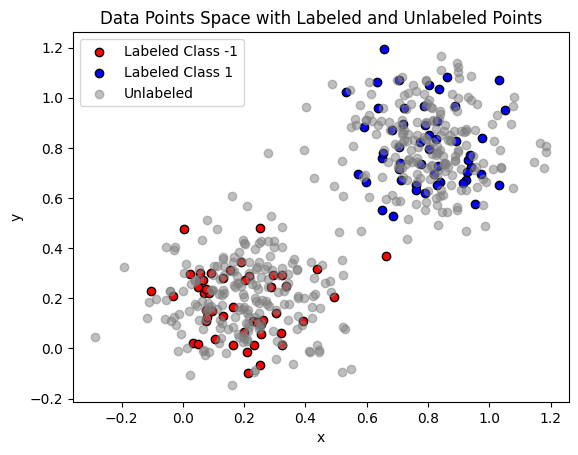

In [2]:
# generation of points in a 2D space

# parameters
n_total = 500                       # total number of point
n_labeled = int(0.2*n_total)        # label 20% of the points
n_unlabeled = n_total - n_labeled   # unlabeled points
n_classes = 2                       # two classes -1 and 1

random_seed = 42
np.random.seed(random_seed)

# Generate two blobs in a 2D space
centers = [(0.2, 0.2), (0.8, 0.8)]
cluster_std = [0.15, 0.15]
X, y_actual = make_blobs(n_samples=n_total, centers=centers, cluster_std = cluster_std, n_features=2, random_state=random_seed)


# Assign labels to a small random subset
index_labels = np.random.choice(n_total, size=n_labeled, replace=False)
labels = np.zeros(n_total)   # initial datapoint space
labels[index_labels] = 2 * y_actual[index_labels] - 1  # convert 0,1 to -1,1
y_labeled = labels[index_labels]
y_unlabeled = labels[np.where(labels == 0)[0]]


# Plot it
plt.figure()
plt.scatter(X[labels == -1, 0], X[labels == -1, 1], color='red', label="Labeled Class -1", edgecolor='k')
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], color='blue', label="Labeled Class 1", edgecolor='k')
plt.scatter(X[labels == 0, 0], X[labels == 0, 1], label="Unlabeled", color='gray', alpha=0.5)
plt.title("Data Points Space with Labeled and Unlabeled Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()



## Part 2 - Similarity Measure Determination


*   To compare the similarity between data points we chose euclidean distance, which measures the physical proximity of the points in the 2D space. We assign this distance metric to the weights between the labeled and unlabeled data points (w_ij) and between unlabeled points (w_ij_bar)


*  In this section, we create the respective weight matrix





In [3]:
# Initialize the weight matrices
w_ij = np.zeros((n_labeled, n_unlabeled))
w_ij_bar = np.zeros((n_unlabeled, n_unlabeled))

# Calculate euclidean distance between labeled and unlabeled
for i in range(n_labeled):
    for j in range(n_unlabeled):
      label_index = index_labels[i]
      unlabeled_index = np.where(labels == 0)[0][j]
      w_ij[i, j] = np.linalg.norm(X[label_index] - X[unlabeled_index])
print("Example of term 1 weight matrix:")
print(w_ij[:5, :5])
print("Shape of term 1 weight matrix:", w_ij.shape)

# Calculate euclidean distance between unlabeled points
for i in range(n_unlabeled):
    for j in range(n_unlabeled):
      unlabeled_index1 = np.where(labels == 0)[0][i]
      unlabeled_index2 = np.where(labels == 0)[0][j]
      w_ij_bar[i, j] = np.linalg.norm(X[unlabeled_index1] - X[unlabeled_index2])

print("\n")
print("Example of term 2 weight matrix:")
print(w_ij_bar[:5, :5])
print("Shape of term 1 weight matrix:",w_ij_bar.shape)

Example of term 1 weight matrix:
[[0.5911015  0.47168058 0.5652034  0.65660175 0.90455216]
 [0.77665882 0.39306182 0.74850003 0.86564688 1.06836155]
 [0.3960064  0.5629214  0.37449115 0.43637443 0.71634324]
 [0.79416213 0.20885109 0.76576234 0.90929234 1.03822761]
 [0.8539729  0.42180128 0.82566116 0.94527795 1.1413614 ]]
Shape of term 1 weight matrix: (100, 400)


Example of term 2 weight matrix:
[[0.         0.64731666 0.02867381 0.13503711 0.32034125]
 [0.64731666 0.         0.62039156 0.77411791 0.85652607]
 [0.02867381 0.62039156 0.         0.15759034 0.34292668]
 [0.13503711 0.77411791 0.15759034 0.         0.32835871]
 [0.32034125 0.85652607 0.34292668 0.32835871 0.        ]]
Shape of term 1 weight matrix: (400, 400)


## Part 3 - Problem Consideration

* Consider the loss function for this problem where two terms define the error: the similarity of unlabeled points to those that are already labeled and the similarity of unlabeled points to those that are also unlabeled:

  $\sum_{i=1}^l $$\sum_{j=1}^{\mu} w_{ij}(y^j-\bar{y}^i)^2 + \frac{1}{2}\sum_{i=1}^{\mu} $$\sum_{j=1}^{\mu} \bar{w}_{ij}(y^i-y^j)^2 $


* To perform optimization, the derivative of the loss function is considered.

  $2*\sum_{i=1}^l w_{ij}(y^j-\bar{y}^i) + 2*\sum_{i=1}^{\mu} \bar{w}_{ij}(y^j-y^i) $






In [4]:
# define the loss function

def loss_function(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y_unlabeled):

    # first term
    term1 = 0
    for i in range(n_labeled):
        for j in range(n_unlabeled):
            term1 += w_ij[i, j] * ((y_unlabeled[j] - y_labeled[i]) ** 2)

    # second term
    term2 = 0
    for i in range(n_unlabeled):
        for j in range(n_unlabeled):
            term2 += w_ij_bar[i, j] * ((y_unlabeled[i] - y_unlabeled[j]) ** 2)

    term2 *= 0.5

    return term1 + term2

In [5]:
# define the derivative of the loss function

def derivative(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y_unlabeled, j):

  #first term
  term1 = 0
  for i in range(n_labeled):
    term1 += w_ij[i, j] * (y_unlabeled[j] - y_labeled[i])

  #second term
  term2 = 0
  for i in range(n_unlabeled):
    term2 += w_ij_bar[i, j] * (y_unlabeled[j] - y_unlabeled[i])

  return 2*term1 + 2*term2

## Part 4(a) - Implement Gradient Descent





#### Gradient Descent with Fixed Step Size

Iteration 0, Loss: 61958.57, Gradient Norm: 6922.298676
Iteration 10, Loss: 21932.06, Gradient Norm: 261.054972
Iteration 20, Loss: 21858.70, Gradient Norm: 37.985601
Iteration 30, Loss: 21854.66, Gradient Norm: 19.907689
Iteration 40, Loss: 21853.46, Gradient Norm: 11.071618
Iteration 50, Loss: 21853.09, Gradient Norm: 6.161614
Iteration 60, Loss: 21852.97, Gradient Norm: 3.429111
Iteration 70, Loss: 21852.94, Gradient Norm: 1.908396
Iteration 80, Loss: 21852.93, Gradient Norm: 1.062076
Iteration 90, Loss: 21852.92, Gradient Norm: 0.591075
Iteration 100, Loss: 21852.92, Gradient Norm: 0.328950
Iteration 110, Loss: 21852.92, Gradient Norm: 0.183070
Iteration 120, Loss: 21852.92, Gradient Norm: 0.101883
Iteration 130, Loss: 21852.92, Gradient Norm: 0.056701


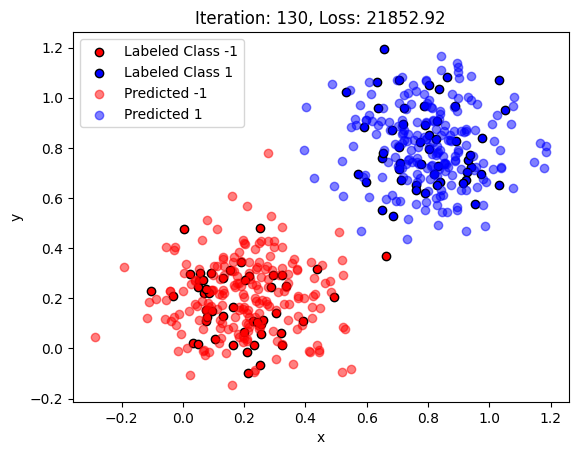

Converged at iteration 130 with a loss of 21852.92 and grad norm 0.06


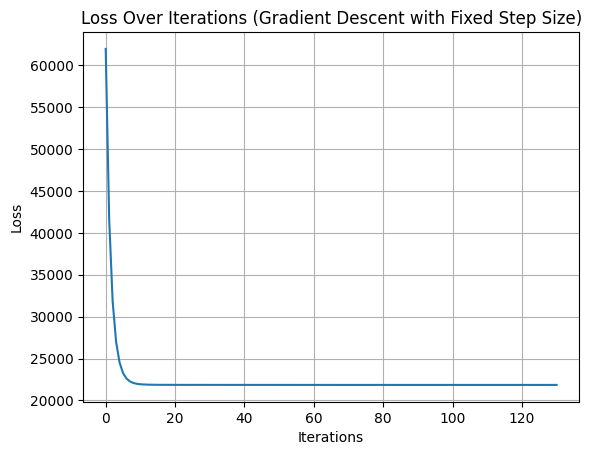

In [6]:
# Perform Gradient Descent with Fixed step size

from IPython.display import clear_output  # Import for clearing output

np.random.seed(23)
y = np.random.uniform(-1, 1, size=n_unlabeled)
max_it = 500
alpha = 0.0005
grad_tolerance = 0.1
loss_history = []
grad_norm_history = []

prev_loss = float('inf')  # Initialize previous loss with a large value

for it in range(max_it):
    current_loss = loss_function(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y)
    loss_history.append(current_loss)

    grad = np.zeros_like(y)
    for k in range(n_unlabeled):
        grad[k] = derivative(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y, k)
    y -= alpha * grad
    grad_norm = np.linalg.norm(grad)
    grad_norm_history.append(grad_norm)

    # ... (rest of your plotting code - no changes needed here) ...
    if it % 10 == 0:  # Update plot every 5 iterations
        clear_output(wait=True)  # Clear previous plot
        for i in range(0, it + 1, 10):
            print(f"Iteration {i}, Loss: {loss_history[i]:.2f}, Gradient Norm: {grad_norm_history[i]:.6f}")

        predicted_labels = np.where(y < 0, -1, 1)
        unlabeled_indices = np.where(labels == 0)[0]

        plt.figure()
        plt.scatter(X[labels == -1, 0], X[labels == -1, 1], color='red', label="Labeled Class -1", edgecolor='k')
        plt.scatter(X[labels == 1, 0], X[labels == 1, 1], color='blue', label="Labeled Class 1", edgecolor='k')
        plt.scatter(X[unlabeled_indices][predicted_labels == 1, 0],
                    X[unlabeled_indices][predicted_labels == 1, 1],
                    color='red', marker='o', label="Predicted -1", alpha=0.5)
        plt.scatter(X[unlabeled_indices][predicted_labels == -1, 0],
                    X[unlabeled_indices][predicted_labels == -1, 1],
                    color='blue', marker='o', label="Predicted 1", alpha=0.5)

        plt.title(f"Iteration: {it}, Loss: {current_loss:.2f}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

        if grad_norm < grad_tolerance:
          print(f"Converged at iteration {it} with a loss of {current_loss:.2f} and grad norm {grad_norm:.2f}")
          break  # Exit the loop if the gradient norm is below the tolerance

        prev_loss = current_loss # Update previous loss

plt.plot(loss_history)
plt.title("Loss Over Iterations (Gradient Descent with Fixed Step Size)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



### Gradient Descent with Armijo Rule Step Size

In [7]:
## Find the Lipshitz constant
## This will be used as starting point alpha (1/L) in armijo

from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh

# Find the laplacian for the similarity matrix w_bar
L_matrix = laplacian(w_ij_bar, normed=False)

# Find largest eigenvalue (spectral norm)
eigvals = eigh(L_matrix, eigvals_only=True)
L_lipschitz = 2 * np.max(eigvals)

print("Lipschitz constant:", f"{L_lipschitz:.2f}")

Lipschitz constant: 768.79


In [8]:
# Perform a grid search of delta and gamma values to optimize the number of iterations needed

import pandas as pd

# Define the parameter grid
delta_values = [0.3, 0.5, 0.8]  # Example delta values
gamma_values = [0.0001, 0.1, 0.5]  # Example gamma values
max_it = 100
loss_tolerance = 1e-2

# Initialize a dictionary to store results
results = {}

# Grid search loop
for delta in delta_values:
    for gamma in gamma_values:
        # Initialize y and other variables for each parameter combination
        np.random.seed(42)  # Reset random seed for consistency
        y = np.random.uniform(-1, 1, size=n_unlabeled)
        loss_history = []

        # Gradient descent with current parameters
        for it in range(max_it):
            current_loss = loss_function(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y)
            loss_history.append(current_loss)

            grad = np.zeros_like(y)
            for k in range(n_unlabeled):
                grad[k] = derivative(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y, k)

            grad_norm = np.linalg.norm(grad)
            grad_norm_history.append(grad_norm)

            # Armijo step size calculation
            alpha = 1 / L_lipschitz  # Starting value
            while loss_function(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y - alpha * grad) > current_loss - delta * alpha * (grad_norm ** 2):
                alpha *= gamma

            y -= alpha * grad  # Update y


            # Check for convergence
            loss_diff = abs(current_loss - prev_loss)
            if loss_diff < loss_tolerance:
              results[(delta, gamma)] = {'loss': loss_function(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y), 'iterations': it}
              break

            prev_loss = current_loss  # Update previous loss for next iteration

            # Store final loss and iterations if not converged within max_it
            if it == max_it - 1:
                results[(delta, gamma)] = {'loss': loss_function(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y), 'iterations': max_it}

# Print the results for all parameter combinations
table_data = []
for (delta, gamma), result in results.items():
    table_data.append({'Delta': delta, 'Gamma': gamma, 'Loss': result['loss'], 'Iterations': result['iterations']})
results_table = pd.DataFrame(table_data)
display(results_table)

# Find the best parameters
best_params = min(results, key=lambda k: results[k]['iterations'])
print(f"\nBest parameters: Delta = {best_params[0]}, Gamma = {best_params[1]}")
print(f"Loss: {results[best_params]['loss']:.2f}, Iterations: {results[best_params]['iterations']}")


,Delta,Gamma,Loss,Iterations
0,0.3,0.0001,21852.938648,19
1,0.3,0.1000,21852.938648,19
2,0.3,0.5000,21852.938648,19
3,0.5,0.0001,21852.938648,19
4,0.5,0.1000,21852.938648,19
5,0.5,0.5000,21852.938648,19
6,0.8,0.0001,60280.654653,100
7,0.8,0.1000,21852.938617,97
8,0.8,0.5000,21852.937575,27



Best parameters: Delta = 0.3, Gamma = 0.0001
Loss: 21852.94, Iterations: 19


Iteration 0, Loss: 60864.6287, Gradient Norm: 6726.138095
Iteration 5, Loss: 21855.5410, Gradient Norm: 31.216719
Iteration 10, Loss: 21853.3479, Gradient Norm: 9.855413
Iteration 15, Loss: 21853.0072, Gradient Norm: 4.422096
Iteration 20, Loss: 21852.9386, Gradient Norm: 1.984426
Iteration 25, Loss: 21852.9248, Gradient Norm: 0.890516
Iteration 30, Loss: 21852.9221, Gradient Norm: 0.399621
Iteration 35, Loss: 21852.9215, Gradient Norm: 0.179331
Iteration 40, Loss: 21852.9214, Gradient Norm: 0.080475


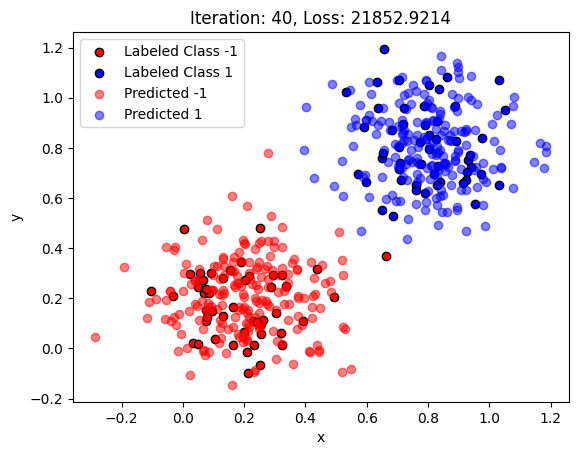

Converged at iteration 40 with a loss of 21852.92 and grad norm 0.08


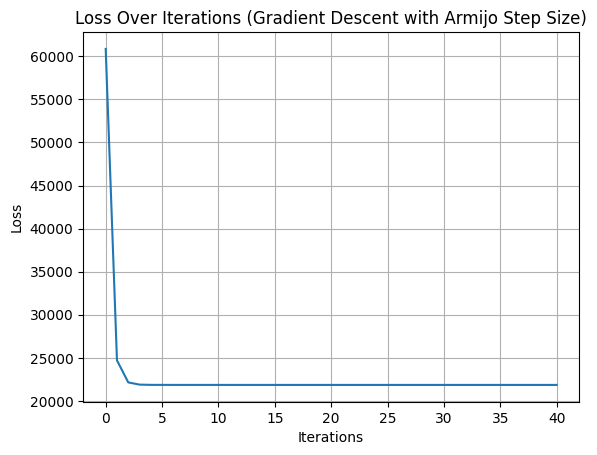

In [9]:
# Since multiple armijo parameters led to low iterations, one of these optimal combinations was selected for our model

np.random.seed(42)
y = np.random.uniform(-1, 1, size=n_unlabeled)  # Initialize y within [0, 1]
max_it = 500
grad_tolerance = 0.1

loss_history = []
grad_norm_history = []

prev_loss = float('inf')

# Armijo parameters
delta = 0.5
gamma = 0.1

for it in range(max_it):
    current_loss = loss_function(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y)
    loss_history.append(current_loss)

    grad = np.zeros_like(y)
    for k in range(n_unlabeled):
        grad[k] = derivative(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y, k)

    grad_norm = np.linalg.norm(grad)
    grad_norm_history.append(grad_norm)

    # Armijo step size calculation
    alpha = 1 / L_lipschitz  # Starting value
    while loss_function(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y - alpha * grad) > current_loss - delta * alpha * (grad_norm ** 2):
        alpha *= gamma

    y -= alpha * grad  # Update y

    if it % 5 == 0:  # Update plot every 5 iterations
        clear_output(wait=True)  # Clear previous plot
        for i in range(0, it + 1, 5):
            print(f"Iteration {i}, Loss: {loss_history[i]:.4f}, Gradient Norm: {grad_norm_history[i]:.6f}")

        predicted_labels = np.where(y < 0, -1, 1)
        unlabeled_indices = np.where(labels == 0)[0]

        plt.figure()
        plt.scatter(X[labels == -1, 0], X[labels == -1, 1], color='red', label="Labeled Class -1", edgecolor='k')
        plt.scatter(X[labels == 1, 0], X[labels == 1, 1], color='blue', label="Labeled Class 1", edgecolor='k')
        plt.scatter(X[unlabeled_indices][predicted_labels == 1, 0],
                    X[unlabeled_indices][predicted_labels == 1, 1],
                    color='red', marker='o', label="Predicted -1", alpha=0.5)
        plt.scatter(X[unlabeled_indices][predicted_labels == -1, 0],
                    X[unlabeled_indices][predicted_labels == -1, 1],
                    color='blue', marker='o', label="Predicted 1", alpha=0.5)

        plt.title(f"Iteration: {it}, Loss: {current_loss:.4f}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

        # Check for convergence
        loss_diff = abs(current_loss - prev_loss)
        if grad_norm < grad_tolerance:
          print(f"Converged at iteration {it} with a loss of {current_loss:.2f} and grad norm {grad_norm:.2f}")
          break  # Exit the loop if the gradient norm is below the tolerance

        prev_loss = current_loss  # Update previous loss for next iteration

plt.plot(loss_history)
plt.title("Loss Over Iterations (Gradient Descent with Armijo Step Size)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



### Gradient Descent

## Part 4(b) - Implement Block Coordinate Gradient Descent with Gauss-Southwell

In [10]:
# define a function that performs the BCGD algorithm with GS update rule

def bcgd_gs(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y_initial, max_it, alpha):

  y = y_initial.copy()
  loss_history = []
  n_unlabeled = len(y)

  for it in range(max_it):
    current_loss = loss_function(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y)
    loss_history.append(current_loss)

    for k in range(n_unlabeled):
      # Calculate the gradient for the current variable
      max_gradient = 0
      gradient_k = derivative(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y, k)

      # Gauss-Southwell selection (within the block of size 1)
      # check if the current gradient is the largest within the block
      if k == 0 or abs(gradient_k) > abs(max_gradient):
        max_gradient = gradient_k
        max_gradient_index = k

      # Update only the selected coordinate within the dimension/block
      y[max_gradient_index] -= alpha * max_gradient

    return y, loss_history



Iteration 0, Loss: 60864.63, Gradient Norm: 2811.398094
Iteration 5, Loss: 21872.80, Gradient Norm: 68.966505
Iteration 10, Loss: 21853.27, Gradient Norm: 7.910665
Iteration 15, Loss: 21852.99, Gradient Norm: 3.404822
Iteration 20, Loss: 21852.93, Gradient Norm: 1.527185
Iteration 25, Loss: 21852.92, Gradient Norm: 0.685324
Iteration 30, Loss: 21852.92, Gradient Norm: 0.307545
Iteration 35, Loss: 21852.92, Gradient Norm: 0.138013


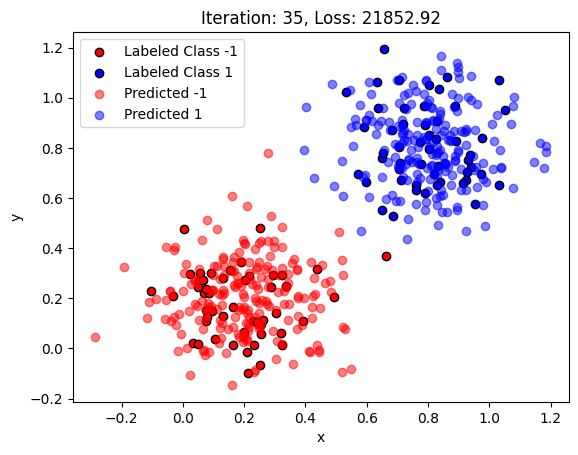

Converged at iteration 38 with a loss of 21852.92 and grad norm 0.09


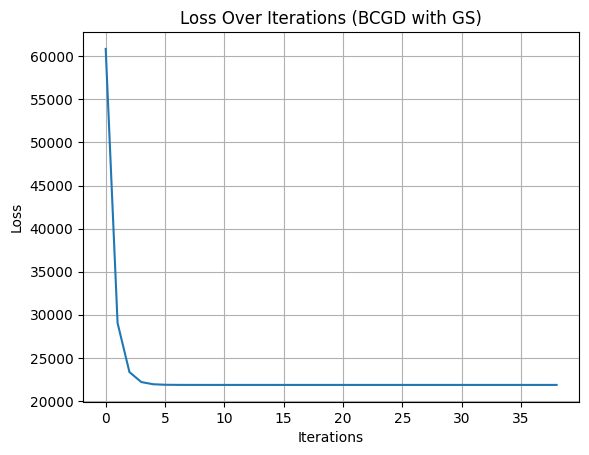

In [11]:
# Perform the optimization with BCGD with GS

from IPython.display import clear_output  # Import for clearing output

np.random.seed(42)
y = np.random.uniform(-1, 1, size=n_unlabeled)  # Initialize y
max_it = 500
alpha = 0.001
grad_tolerance = 0.1
loss_history = []
grad_norm_history = []  # For consistency with previous code

prev_loss = float('inf')

for it in range(max_it):
    # Perform one iteration of BCGD with Dimension 1 and GS
    y, current_loss_history = bcgd_gs(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y, 1, alpha)
    current_loss = current_loss_history[-1]  # Get the last loss value from the history
    loss_history.append(current_loss)

    # Calculate gradients for all unlabeled points (for grad_norm_history)
    grad = np.zeros_like(y)
    for k in range(n_unlabeled):
        grad[k] = derivative(n_labeled, n_unlabeled, w_ij, w_ij_bar, y_labeled, y, k)
    grad_norm = np.linalg.norm(grad)
    grad_norm_history.append(grad_norm)


    # Visualization every 5 iterations
    if it % 5 == 0:
        clear_output(wait=True)
        for i in range(0, it + 1, 5):
            print(f"Iteration {i}, Loss: {loss_history[i]:.2f}, Gradient Norm: {grad_norm_history[i]:.6f}")

        predicted_labels = np.where(y < 0, -1, 1)
        unlabeled_indices = np.where(labels == 0)[0]

        plt.figure()
        plt.scatter(X[labels == -1, 0], X[labels == -1, 1], color='red', label="Labeled Class -1", edgecolor='k')
        plt.scatter(X[labels == 1, 0], X[labels == 1, 1], color='blue', label="Labeled Class 1", edgecolor='k')
        plt.scatter(X[unlabeled_indices][predicted_labels == 1, 0],
                    X[unlabeled_indices][predicted_labels == 1, 1],
                    color='red', marker='o', label="Predicted -1", alpha=0.5)
        plt.scatter(X[unlabeled_indices][predicted_labels == -1, 0],
                    X[unlabeled_indices][predicted_labels == -1, 1],
                    color='blue', marker='o', label="Predicted 1", alpha=0.5)

        plt.title(f"Iteration: {it}, Loss: {current_loss:.2f}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

    # Check for convergence
    loss_diff = abs(current_loss - prev_loss)
    if grad_norm < grad_tolerance:
      print(f"Converged at iteration {it} with a loss of {current_loss:.2f} and grad norm {grad_norm:.2f}")
      break

    prev_loss = current_loss

plt.plot(loss_history)
plt.title("Loss Over Iterations (BCGD with GS)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Part 5 - Test Algorithm with Publicly Available Datasets

### Using the breast cancer data set, we apply our problem to determine if we can predict whether breast cancer tumors are malignant (-1) or benign (1) given the physical description of a tumor size, shape, etc. We first upload the dataset, split the data into training and test sets, standardize the data to more efficiently work with, then apply our problem on the training set. Through the training set we apply both gradient descent and block coordinate gradient descent to determine which optimization method is most efficient (leads to global minimum in the least amount of iterations).

### Once we determine the BCGD algorithm with GS update rule performed the best ont he training set, we applied it to the test set. Accuracies are calculated for each of the algorithms based on known labels.


### Cancer Data - Cleaning and Preperation of Data

In [12]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
cancer_df = pd.DataFrame(data.data, columns=data.feature_names)
data.target = 2 * data.target - 1  # 0 → -1 (malignant), 1 → 1 (benign)
cancer_df['target'] = data.target
cancer_df['target_name'] = cancer_df['target'].map({-1: 'malignant', 1: 'benign'})
cancer_df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,target_name
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,-1,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,-1,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,-1,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,-1,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,-1,malignant


In [13]:
# Split the data into training and test sets

from sklearn.model_selection import train_test_split
X_train = cancer_df.drop(['target', 'target_name'], axis=1)
y_train = cancer_df['target']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (455, 30)
y_train shape: (455,)
X_test shape: (114, 30)
y_test shape: (114,)


In [14]:
# Split the training set into 20% labeled points and 80% unlabeled points

# Assume y_train is in {-1, 1}
n_labeled = int(0.2 * len(y_train))
n_unlabeled = len(y_train) - n_labeled

indices = np.arange(len(y_train))
np.random.shuffle(indices)
labeled_idx = indices[:n_labeled]
unlabeled_idx = indices[n_labeled:]

# Create labeled and unlabeled masks
y_train_np = y_train.to_numpy()
y_train_semi = np.zeros_like(y_train, dtype=float)
y_train_semi[labeled_idx] = y_train_np[labeled_idx]
y_labeled_cancer = y_train_semi[labeled_idx]
y_unlabeled_cancer = y_train_semi[unlabeled_idx]


In [15]:
# Split the y_test into 20% labeled and 80% unlabeled points

n_labeled_test = int(0.2 * len(y_test))
n_unlabeled_test = len(y_test) - n_labeled_test

indices_test = np.arange(len(y_test))
np.random.shuffle(indices_test)
labeled_idx_test = indices_test[:n_labeled_test]
unlabeled_idx_test = indices_test[n_labeled_test:]

In [16]:
# Standardize the data using MinMaxScaler

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()  # MinMaxScaler value

# Fit on training data
scaler.fit(X_train)

# Transform training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
# Make the similarity matrices - training data

# Similarity between labeled and unlabeled points by euclidean distance
w_cancer = np.zeros((len(y_labeled_cancer), len(y_unlabeled_cancer)))
for i in range(len(y_labeled_cancer)):
  for j in range(len(y_unlabeled_cancer)):
    w_cancer[i, j] = np.linalg.norm(X_train_scaled[labeled_idx[i]] - X_train_scaled[unlabeled_idx[j]])

print(w_cancer[:5])
print(w_cancer.shape)

# Similarity between unlabeled points by euclidean distance
w_bar_cancer = np.zeros((len(y_unlabeled_cancer), len(y_unlabeled_cancer)))
for i in range(len(y_unlabeled_cancer)):
  for j in range(len(y_unlabeled_cancer)):
    w_bar_cancer[i, j] = np.linalg.norm(X_train_scaled[unlabeled_idx[i]] - X_train_scaled[unlabeled_idx[j]])

print(w_bar_cancer[:5])
print(w_bar_cancer.shape)


# Make similarity matrices for the test set
w_cancer_test = np.zeros((len(y_labeled_cancer), len(y_test)))
for i in range(len(y_labeled_cancer)):
    for j in range(len(y_test)):
        w_cancer_test[i, j] = np.linalg.norm(X_train_scaled[labeled_idx[i]] - X_test_scaled[j])

w_bar_cancer_test = np.zeros((len(y_test), len(y_test)))
for i in range(len(y_test)):
    for j in range(len(y_test)):
        w_bar_cancer_test[i, j] = np.linalg.norm(X_test_scaled[i] - X_test_scaled[j])

[[0.64326482 1.38395574 1.41823837 ... 1.1901971  0.82526143 0.8741139 ]
 [1.06954297 0.55987055 0.64898619 ... 0.86835653 1.00737855 1.04204537]
 [0.47818418 0.6984836  0.76403192 ... 0.68166827 0.42414451 0.47179619]
 [0.91195259 0.47623034 0.51433298 ... 0.56563042 0.99040126 1.05181038]
 [0.99570254 0.34480219 0.23850802 ... 0.52671191 1.02750194 1.08800868]]
(91, 364)
[[0.         0.87160979 0.96443908 ... 0.74381584 0.41034764 0.44087653]
 [0.87160979 0.         0.3118808  ... 0.52661225 0.91962938 0.94498459]
 [0.96443908 0.3118808  0.         ... 0.43969174 1.03919834 1.07460536]
 [0.90214474 0.2299196  0.3135799  ... 0.57186702 0.92563628 0.94573491]
 [0.58129132 0.51228269 0.56540148 ... 0.47973623 0.56758759 0.59664902]]
(364, 364)


In [18]:
# Define the function that will calculate the accuracy of our problem

def calc_accuracy(y_actual, y_predicted, labeled_idx, unlabeled_idx):

  # Create an array to store all predicted labels (labeled and unlabeled)
  predicted_labels_all = np.zeros_like(y_actual)  # Initialize with the correct size

  # Assign the known labels for the labeled data points
  predicted_labels_all[labeled_idx] = y_actual[labeled_idx]  # Use y_actual here

  # Assign the predicted labels for the unlabeled data points
  predicted_labels_all[unlabeled_idx] = np.where(y_predicted < 0, -1, 1)

  # Calculate and return the accuracy using accuracy_score
  accuracy = accuracy_score(y_actual, predicted_labels_all)

  return accuracy

### Cancer Data - Gradient Descent with Fixed Step Size

Iteration 0, Loss: 92767.94, Gradient Norm: 11027.242517
Iteration 50, Loss: 32259.44, Gradient Norm: 401.145997
Iteration 100, Loss: 31913.69, Gradient Norm: 150.770911
Iteration 150, Loss: 31861.89, Gradient Norm: 59.045452
Iteration 200, Loss: 31853.94, Gradient Norm: 23.125536
Iteration 250, Loss: 31852.72, Gradient Norm: 9.057269
Iteration 300, Loss: 31852.53, Gradient Norm: 3.547339
Iteration 350, Loss: 31852.51, Gradient Norm: 1.389339
Iteration 400, Loss: 31852.50, Gradient Norm: 0.544144
Iteration 450, Loss: 31852.50, Gradient Norm: 0.213117
Converged at iteration 491 with a loss of 31852.50 and grad norm 0.10


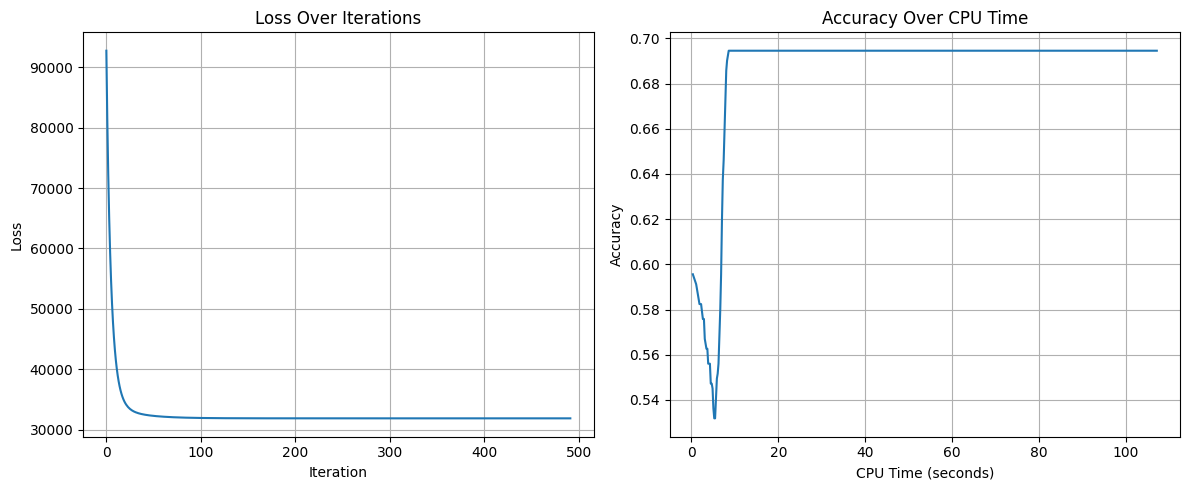

Accuracy on the training set: 0.7
Total CPU time: 107.49 seconds


In [19]:
# Perform Gradient Descent with Fixed Step Size

from os import cpu_count
import time

np.random.seed(23)
y_cancer = np.random.uniform(-1, 1, size=len(y_unlabeled_cancer))


max_it = 500
alpha = 0.0001
grad_tolerance = 0.1  # Set a tolerance for the absolute change in loss
loss_history = []
grad_norm_history = []
accuracy_history = []  # Initialize list to store accuracy values
cpu_time_history = []  # Initialize list to store CPU time values

prev_loss = float('inf')  # Initialize previous loss with a large value

start_time = time.time()  # Record the starting time

for it in range(max_it):
    current_loss = loss_function(len(y_labeled_cancer), len(y_unlabeled_cancer), w_cancer, w_bar_cancer, y_labeled_cancer, y_cancer)
    loss_history.append(current_loss)

    grad = np.zeros_like(y_cancer)
    for k in range(len(y_unlabeled_cancer)):
        grad[k] = derivative(len(y_labeled_cancer), len(y_unlabeled_cancer), w_cancer, w_bar_cancer, y_labeled_cancer, y_cancer, k)
    y_cancer -= alpha * grad
    grad_norm = np.linalg.norm(grad)
    grad_norm_history.append(grad_norm)

    # Calculate and store accuracy for current iteration
    accuracy = calc_accuracy(y_train_np, y_cancer, labeled_idx, unlabeled_idx)
    accuracy_history.append(accuracy)

    # Record CPU time for current iteration
    cpu_time_history.append(time.time() - start_time)

    if it % 50 == 0:  # Update plot every 5 iterations
        clear_output(wait=True)  # Clear previous plot
        for i in range(0, it + 1, 50):
            print(f"Iteration {i}, Loss: {loss_history[i]:.2f}, Gradient Norm: {grad_norm_history[i]:.6f}")

    cancer_predicted_labels = np.where(y < 0, -1, 1)
    unlabeled_indices = np.where(labels == 0)[0]

    # Check for convergence
    loss_diff = abs(current_loss - prev_loss)
    if grad_norm < grad_tolerance:
      print(f"Converged at iteration {it} with a loss of {current_loss:.2f} and grad norm {grad_norm:.2f}")
      break

    prev_loss = current_loss # Update previous loss

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss vs iterations
ax1.plot(loss_history)
ax1.set_title("Loss Over Iterations")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot accuracy vs iterations
ax2.plot(cpu_time_history, accuracy_history)  # Change x-axis to cpu_time_history
ax2.set_title("Accuracy Over CPU Time")
ax2.set_xlabel("CPU Time (seconds)")
ax2.set_ylabel("Accuracy")
ax2.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


print(f"Accuracy on the training set: {calc_accuracy(y_train_np, y_cancer, labeled_idx, unlabeled_idx):.1f}")
print(f"Total CPU time: {time.time() - start_time:.2f} seconds")


### Cancer Data - Gradient Descent with Armijo Rule Step Size

In [20]:
# Find the lipschitz constant

# Find the laplacian for the similarity matrix w_bar
L_matrix = laplacian(w_bar_cancer, normed=False)

# Find largest eigenvalue (spectral norm)
eigvals = eigh(L_matrix, eigvals_only=True)
L_cancer = 2 * np.max(eigvals)

print("Lipschitz constant:", L_cancer)


Lipschitz constant: 1965.3108613401332


Iteration 0, Loss: 92767.9435, Gradient Norm: 11027.242517
Iteration 50, Loss: 31852.7595, Gradient Norm: 9.805322
Converged at iteration 97 with a loss of 31852.50 and grad norm 0.09


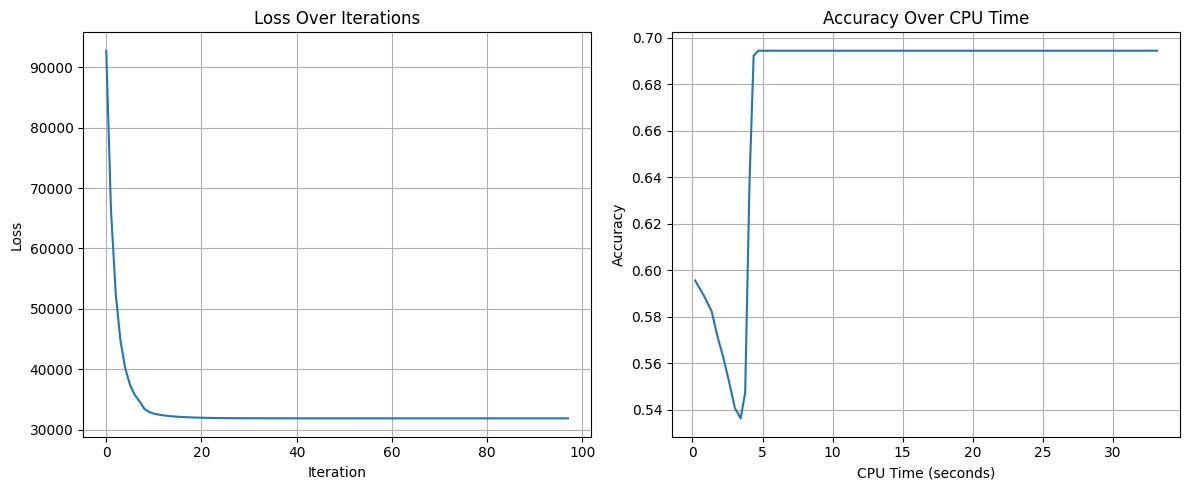

Accuracy on the training set: 0.7
Total CPU time: 33.70 seconds


In [21]:
# Gradient Descent with Armijo Step Size Rule

np.random.seed(23)
y_cancer = np.random.uniform(-1, 1, size=len(y_unlabeled_cancer))  # Initialize y within [0, 1]
max_it = 1000
grad_tolerance = 0.1

loss_history = []
grad_norm_history = []
accuracy_history = []  # Initialize list to store accuracy values
cpu_time_history = []  # Initialize list to store CPU time


prev_loss = float('inf')

start_time = time.time()  # Record the starting time

# Armijo parameters
delta = 0.8
gamma = 0.5

for it in range(max_it):
    current_loss = loss_function(len(y_labeled_cancer), len(y_unlabeled_cancer), w_cancer, w_bar_cancer, y_labeled_cancer, y_cancer)
    loss_history.append(current_loss)

    grad = np.zeros_like(y_cancer)
    for k in range(len(y_unlabeled_cancer)):
        grad[k] = derivative(len(y_labeled_cancer), len(y_unlabeled_cancer), w_cancer, w_bar_cancer, y_labeled_cancer, y_cancer, k)

    grad_norm = np.linalg.norm(grad)
    grad_norm_history.append(grad_norm)

    # Calculate and store accuracy for current iteration
    accuracy = calc_accuracy(y_train_np, y_cancer, labeled_idx, unlabeled_idx)
    accuracy_history.append(accuracy)

    # Record CPU time for current iteration
    cpu_time_history.append(time.time() - start_time)

    # Armijo step size calculation
    alpha = 1 / L_cancer  # Starting value
    while loss_function(len(y_labeled_cancer), len(y_unlabeled_cancer), w_cancer, w_bar_cancer, y_labeled_cancer, y_cancer - alpha * grad) > current_loss - delta * alpha * (grad_norm ** 2):
        alpha *= gamma

    y_cancer -= alpha * grad  # Update y

    if it % 50 == 0:  # Update plot every 5 iterations
        clear_output(wait=True)  # Clear previous plot
        for i in range(0, it + 1, 50):
            print(f"Iteration {i}, Loss: {loss_history[i]:.4f}, Gradient Norm: {grad_norm_history[i]:.6f}")

    predicted_labels = np.where(y_cancer < 0, -1, 1)
    unlabeled_indices = np.where(labels == 0)[0]

    loss_diff = abs(current_loss - prev_loss)
    if grad_norm < grad_tolerance:
      print(f"Converged at iteration {it} with a loss of {current_loss:.2f} and grad norm {grad_norm:.2f}")
      break

    prev_loss = current_loss  # Update previous loss for next iteration

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss vs iterations
ax1.plot(loss_history)
ax1.set_title("Loss Over Iterations")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot accuracy vs CPU time
ax2.plot(cpu_time_history, accuracy_history)  # Change x-axis to cpu_time_history
ax2.set_title("Accuracy Over CPU Time")
ax2.set_xlabel("CPU Time (seconds)")
ax2.set_ylabel("Accuracy")
ax2.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

print(f"Accuracy on the training set: {calc_accuracy(y_train_np, y_cancer, labeled_idx, unlabeled_idx):.1f}")
print(f"Total CPU time: {time.time() - start_time:.2f} seconds")

### Cancer Data - Block Coordinate Gradient Descent with Gauss-Southwell

Iteration 0, Loss: 92767.94, Gradient Norm: 5288.487397
Iteration 5, Loss: 32821.62, Gradient Norm: 586.426597
Iteration 10, Loss: 32082.73, Gradient Norm: 263.739018
Iteration 15, Loss: 31920.17, Gradient Norm: 142.648983
Iteration 20, Loss: 31872.49, Gradient Norm: 77.527817
Iteration 25, Loss: 31858.41, Gradient Norm: 42.139443
Iteration 30, Loss: 31854.25, Gradient Norm: 22.904483
Iteration 35, Loss: 31853.02, Gradient Norm: 12.449510
Iteration 40, Loss: 31852.65, Gradient Norm: 6.766812
Iteration 45, Loss: 31852.55, Gradient Norm: 3.678036
Iteration 50, Loss: 31852.51, Gradient Norm: 1.999161
Iteration 55, Loss: 31852.50, Gradient Norm: 1.086625
Iteration 60, Loss: 31852.50, Gradient Norm: 0.590625
Iteration 65, Loss: 31852.50, Gradient Norm: 0.321028
Iteration 70, Loss: 31852.50, Gradient Norm: 0.174492
Iteration 75, Loss: 31852.50, Gradient Norm: 0.094843
Converged at iteration 75 with a loss of 31852.50 and grad norm 0.09


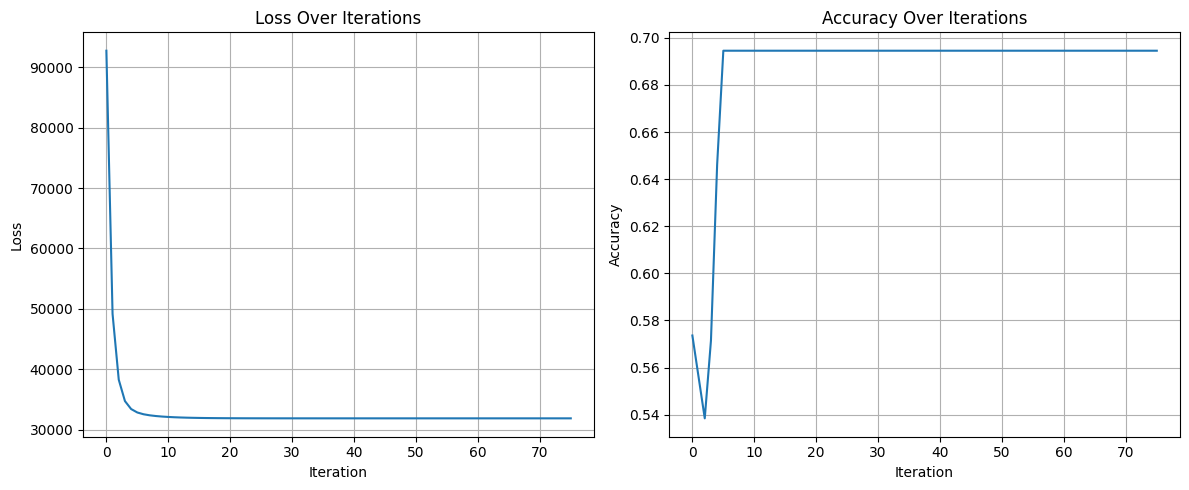

Accuracy on the training set: 0.7
Total CPU time: 24.28 seconds


In [22]:
## Apply block coordinate gradient descent (BCGD) with Gauss-Southwell (GS)

np.random.seed(23)
y_cancer = np.random.uniform(-1, 1, size=len(y_unlabeled_cancer))  # Initialize y within [0, 1]
max_it = 1000
alpha = 0.0005
grad_tolerance = 0.1

loss_history = []
grad_norm_history = []
accuracy_history = []
cpu_time_history = []  # Initialize list to store CPU time

prev_loss = float('inf')

start_time = time.time()  # Record the starting time

for it in range(max_it):
    # Perform one iteration of BCGD with Dimension 1 and GS
    y_cancer, current_loss_history = bcgd_gs(len(y_labeled_cancer), len(y_unlabeled_cancer), w_cancer, w_bar_cancer, y_labeled_cancer, y_cancer, 1, alpha)
    current_loss = current_loss_history[-1]  # Get the last loss value from the history
    loss_history.append(current_loss)

    # Calculate gradients for all unlabeled points (for grad_norm_history)
    grad = np.zeros_like(y_cancer)
    for k in range(len(y_unlabeled_cancer)):
        grad[k] = derivative(len(y_labeled_cancer), len(y_unlabeled_cancer), w_cancer, w_bar_cancer, y_labeled_cancer, y_cancer, k)
    grad_norm = np.linalg.norm(grad)
    grad_norm_history.append(grad_norm)

    # Calculate and store accuracy for current iteration
    accuracy = calc_accuracy(y_train_np, y_cancer, labeled_idx, unlabeled_idx)
    accuracy_history.append(accuracy)

    # Record CPU time for current iteration
    cpu_time_history.append(time.time() - start_time)

    # Visualization every 5 iterations
    if it % 5 == 0:
        clear_output(wait=True)
        for i in range(0, it + 1, 5):
            print(f"Iteration {i}, Loss: {loss_history[i]:.2f}, Gradient Norm: {grad_norm_history[i]:.6f}")

        predicted_labels = np.where(y < 0, -1, 1)
        unlabeled_indices = np.where(labels == 0)[0]

    # Check for convergence
    loss_diff = abs(current_loss - prev_loss)
    if grad_norm < grad_tolerance:
      print(f"Converged at iteration {it} with a loss of {current_loss:.2f} and grad norm {grad_norm:.2f}")
      break

    prev_loss = current_loss

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss vs iterations
ax1.plot(loss_history)
ax1.set_title("Loss Over Iterations")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot accuracy vs iterations
ax2.plot(accuracy_history)
ax2.set_title("Accuracy Over Iterations")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


print(f"Accuracy on the training set: {calc_accuracy(y_train_np, y_cancer, labeled_idx, unlabeled_idx):.1f}")
print(f"Total CPU time: {time.time() - start_time:.2f} seconds")


### Cancer Data - Application to Test Set

In [23]:
# Define the accuracy function for the test set

def calc_accuracy_test(y_actual, y_predicted, labeled_idx_test, unlabeled_idx_test):

    # Create an array to store all predicted labels (labeled and unlabeled)
    predicted_labels_all = np.zeros_like(y_actual)

    # Assign the known labels for the labeled data points
    predicted_labels_all[labeled_idx_test] = y_actual[labeled_idx_test]

    # Assign the predicted labels for the unlabeled data points
    # Use only the predictions for the unlabeled points
    predicted_labels_all[unlabeled_idx_test] = np.where(y_predicted[unlabeled_idx_test] < 0, -1, 1)

    # Calculate and return the accuracy using accuracy_score
    accuracy = accuracy_score(y_actual, predicted_labels_all)
    return accuracy #Added return statement

Iteration 0, Loss: 18928.46, Gradient Norm: 1546.863559
Iteration 5, Loss: 9908.34, Gradient Norm: 181.082432
Iteration 10, Loss: 9790.14, Gradient Norm: 41.998554
Iteration 15, Loss: 9783.46, Gradient Norm: 12.799284
Iteration 20, Loss: 9782.83, Gradient Norm: 4.100816
Iteration 25, Loss: 9782.76, Gradient Norm: 1.323321
Iteration 30, Loss: 9782.76, Gradient Norm: 0.427429
Iteration 35, Loss: 9782.76, Gradient Norm: 0.138067
Converged at iteration 37 with a loss of 9782.76 and grad norm 0.09


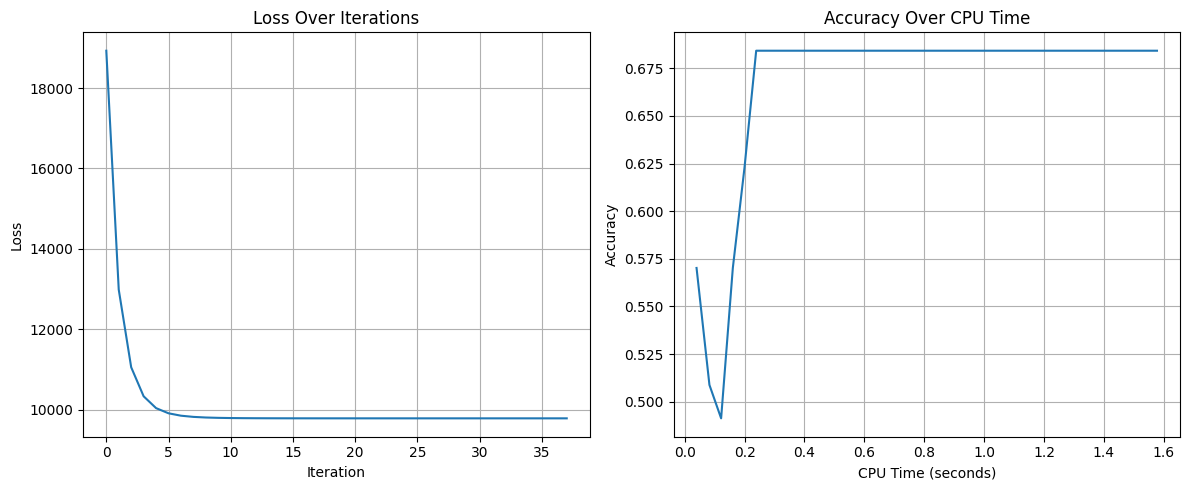

Accuracy on the test set: 0.68
Total CPU time: 1.90 seconds


In [24]:
## Apply the best optimization method found in the training set to the test set
## The BCGD with Gauss-Southwell converged in the least amount of iteration, therefore it was chosen

np.random.seed(23)
y_cancer_test = np.random.uniform(-1, 1, size=len(y_test))
max_it = 1000
alpha = 0.001
grad_tolerance = 0.1

loss_history = []
grad_norm_history = []
accuracy_history = []
cpu_time_history = []  # Initialize list to store CPU time

prev_loss = float('inf')

start_time = time.time()  # Record the starting time

for it in range(max_it):
    # Perform one iteration of BCGD with Dimension 1 and GS
    y_cancer_test, current_loss_history = bcgd_gs(len(y_labeled_cancer), len(y_test), w_cancer_test, w_bar_cancer_test, y_labeled_cancer, y_cancer_test, 1, alpha)
    current_loss = current_loss_history[-1]  # Get the last loss value from the history
    loss_history.append(current_loss)

    # Calculate gradients for all unlabeled points (for grad_norm_history)
    grad = np.zeros_like(y_cancer_test)
    # Change the range of the loop to match the size of y_cancer_test
    for k in range(len(y_cancer_test)):
        grad[k] = derivative(len(y_labeled_cancer), len(y_test), w_cancer_test, w_bar_cancer_test, y_labeled_cancer, y_cancer_test, k)
    grad_norm = np.linalg.norm(grad)
    grad_norm_history.append(grad_norm)

    # Calculate and store accuracy for current iteration
    accuracy = calc_accuracy_test(y_test.to_numpy(), y_cancer_test, labeled_idx_test, unlabeled_idx_test)
    accuracy_history.append(accuracy)

    # Record CPU time for current iteration
    cpu_time_history.append(time.time() - start_time)

    # Visualization every 5 iterations
    if it % 5 == 0:
        clear_output(wait=True)
        for i in range(0, it + 1, 5):
            print(f"Iteration {i}, Loss: {loss_history[i]:.2f}, Gradient Norm: {grad_norm_history[i]:.6f}")

    predicted_labels = np.where(y_cancer_test < 0, -1, 1) # Use y_cancer_test here
    unlabeled_indices = np.where(labels == 0)[0]

    # Check for convergence
    loss_diff = abs(current_loss - prev_loss)
    if grad_norm < grad_tolerance:
      print(f"Converged at iteration {it} with a loss of {current_loss:.2f} and grad norm {grad_norm:.2f}")
      break

    prev_loss = current_loss

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss vs iterations
ax1.plot(loss_history)
ax1.set_title("Loss Over Iterations")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot accuracy vs CPU time
ax2.plot(cpu_time_history, accuracy_history)  # Change x-axis to cpu_time_history
ax2.set_title("Accuracy Over CPU Time")
ax2.set_xlabel("CPU Time (seconds)")
ax2.set_ylabel("Accuracy")
ax2.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Use y_cancer_test for accuracy calculation
print(f"Accuracy on the test set: {calc_accuracy_test(y_test.to_numpy(), y_cancer_test, labeled_idx_test, unlabeled_idx_test):.2f}")
print(f"Total CPU time: {time.time() - start_time:.2f} seconds")